In [32]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

Dataset Generation and Preprocessing

In [33]:
def count(vector, value):
    elements_equal_to_value = tf.equal(vector, value)           # Returns a tf.tensor of booleans (True = value found at this position).
    as_intengers = tf.cast(elements_equal_to_value, tf.int32)     
    count = tf.reduce_sum(as_intengers)                         # Sums the occurences of the value up.
    return count

def get_context():
  context = tf.random.uniform(shape = [2], minval = 0, maxval = 10, dtype = tf.dtypes.int32)
  while(1):                                                     # Check to ensure that the context does not contain the same digit two times.
    if context[0] != context[1]:
      break
    elif context[0] == context[1]:
      context = tf.random.uniform(shape = [2], minval = 0, maxval = 10, dtype = tf.dtypes.int32)
  return context

def get_sequence(n_timesteps):
  sequence = tf.random.uniform(shape = [n_timesteps], minval = 0, maxval = 10, dtype = tf.dtypes.int32)
  return sequence

def get_target(context, sequence):
  count_first_digit = count(sequence, context[0])
  count_second_digit = count(sequence, context[1])

  target = 0
  if count_first_digit > count_second_digit:
    target = 0  
  elif count_first_digit < count_second_digit:
    target = 1
  elif count_first_digit == count_second_digit:
    target = 2   
    
  target = tf.one_hot(target, 3)
  return target 

def generate_dataset(batch_size, n_timesteps):
  inputs = []
  targets = []
  for i in range(batch_size):
    context = get_context()
    sequence = get_sequence(n_timesteps)
    targets.append(get_target(context, sequence))

    context = tf.one_hot(context, 10)
    sequence = tf.one_hot(sequence, 10)
    inps = []
    for step in range(n_timesteps):  
      inps.append(tf.concat((context, tf.expand_dims(sequence[step], axis = 0)), axis = 0))
    inputs.append(inps)

  input_dataset = tf.data.Dataset.from_tensor_slices(inputs)
  target_dataset = tf.data.Dataset.from_tensor_slices(targets)
  dataset = tf.data.Dataset.zip((input_dataset, target_dataset))
  dataset = dataset.batch(batch_size).prefetch(batch_size)  
  return dataset                 

LSTM cell class

In [34]:
class LSTMCell(tf.keras.Model):

  def __init__(self, state_size):
    super(LSTMCell, self).__init__()

    self.forget_gate = tf.keras.layers.Dense(units = state_size,                    
                                             activation = tf.keras.activations.sigmoid,
                                             bias_initializer = 'ones')                   # Setting the biases of the forget gate to one initially.

    self.input_gate = tf.keras.layers.Dense(units = state_size,
                                            activation = tf.keras.activations.sigmoid)
    
    self.output_gate = tf.keras.layers.Dense(units = state_size,
                                             activation = tf.keras.activations.sigmoid)

    self.cell_state_candidates = tf.keras.layers.Dense(units = state_size,
                                                       activation = tf.keras.activations.tanh)


  def call(self, input, states):
    (old_hidden_state, old_cell_state) = states
    concat_input = tf.expand_dims(tf.concat((old_hidden_state, input), axis = 0), axis = 0)   

    old_cell_state = old_cell_state * self.forget_gate(concat_input)
    update = self.input_gate(concat_input) * self.cell_state_candidates(concat_input) 
    new_cell_state = old_cell_state + update
    new_hidden_state = tf.keras.activations.tanh(new_cell_state) * self.output_gate(concat_input)

    return (tf.squeeze(new_hidden_state), tf.squeeze(new_cell_state))

LSTM class

In [35]:
class LSTM(tf.keras.Model):
    
  def __init__(self, state_size):
    super(LSTM, self).__init__()

    self.state_size = state_size
    self.lstm_cell = LSTMCell(state_size)
        

  def call(self, input, zero_states):
    states = zero_states    

    output = []
    for sequence in input:                              # Iterate over each sequence (item of batch).
      for inp in sequence:                              # Iterate over each context-sequence input pair.
        states = self.lstm_cell(inp, states)            # Call the LSTM cell with its own output "states"
      (current_output, _) = states 
      output.append(current_output)
    
    output = tf.reshape(tf.convert_to_tensor(output), shape = [-1, self.state_size])       # Batch of outputs.
    return output

Model class

In [36]:
class Model(tf.keras.Model):
    
  def __init__(self, state_size, n_timesteps):
    super(Model, self).__init__()

    self.input_layer = tf.keras.layers.Reshape((n_timesteps, 30))                           # (n_timesteps of input, length of the one-hot encoded input vector) 
    self.lstm = LSTM(state_size)
    self.output_layer = tf.keras.layers.Dense(units = 3,                                  
                                              activation = tf.keras.activations.softmax)    # 0 = first digit, 1 = second digit, 2 = equally frequent


  def call(self, input, zero_states):
    x = self.input_layer(input)
    x = self.lstm(tf.squeeze(x), zero_states)
    x = self.output_layer(x)
   
    return x

Training

In [37]:
def training_step(model, dataset, loss_fn, optimizer, zero_states):
  training_losses = []
  training_accuracies = []

  for (input, target) in dataset:
    with tf.GradientTape() as tape:
      prediction = model(input, zero_states)
      current_loss = loss_fn(target, prediction)
      gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    training_losses.append(current_loss.numpy())

    current_accuracy = np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1)
    training_accuracies.append(np.mean(current_accuracy))   
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy

In [44]:
tf.keras.backend.clear_session()

state_size = 10
init_hidden_state = tf.zeros(shape = [state_size])
init_cell_state = tf.zeros(shape = [state_size])
zero_states = (init_hidden_state, init_cell_state)          # Call the LSTM with zero state initially.  
n_timesteps = 100         
model = Model(state_size, n_timesteps)

n_epochs = 20
learning_rate = 0.001
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)   

training_losses = []
training_accuracies = []

# Training and test loop
for epoch in range(n_epochs):
  print('Epoch ' + str(epoch))

  dataset = generate_dataset(batch_size, n_timesteps)
  training_loss, training_accuracy = training_step(model, dataset, loss_fn, optimizer, zero_states)
  training_losses.append(training_loss)
  training_accuracies.append(training_accuracy)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Visualization

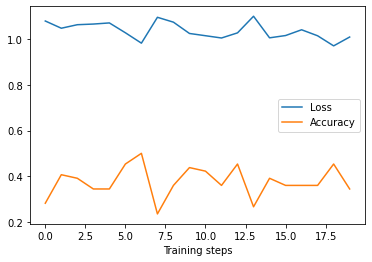

In [45]:
# Description: The figure shows the loss and the accuracy for each epoch during the training of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(training_accuracies)
plt.xlabel("Training steps")
plt.legend((line1, line2),("Loss", "Accuracy"))
plt.show()